# Statistical foundation of machine learning

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.decomposition import PCA

import torch

from xgboost import XGBRegressor

from config.regressors import *
from config.models import *
from config.loss_functions import *
from config.transformers import *
from config.validation import *
from config.dann import *

import pyriemann

# adjust import if needed

In [2]:
# loading raw data
# PATH = f'/Users/marco/PROJECTS/data/'
PATH = r'C:\Users\gianm\Documents\Uni\Big Data\F422\project\data\\'
DATASET = 'guided' # change this to guided/freemoves if needed

X_guided = np.load(PATH + f'{DATASET}/{DATASET}_dataset_X.npy')
Y_guided = np.load(PATH + f'{DATASET}/{DATASET}_dataset_Y.npy')

DATASET = 'freemoves' # change this to guided/freemoves if needed

X_freemoves = np.load(PATH + f'{DATASET}/{DATASET}_dataset_X.npy')
Y_freemoves = np.load(PATH + f'{DATASET}/{DATASET}_dataset_Y.npy')

## (Optional) Signal filtering

if you plan to filter your sEMG signals, it is recommended to perform
this preprocessing step directly on the continuous raw data prior to window extraction or feature
computation. Note that this step is completely optional but may improve your results.

### 

To ensure the quality of the EMG signals and remove unwanted noise, we apply a series of digital signal processing filters. The filtering process is crucial for obtaining clean and reliable EMG data, which is essential for accurate hand gesture classification.

### Filtering Steps

The `EmgFilterTransformer` class implements the following filtering steps:

1.  **Resampling:** The EMG signals are initially resampled from their original sampling frequency (`original_fs` = 1024 Hz) to a higher target sampling frequency (`target_fs` = 2048 Hz).
Upsampling is performed to minimize high-frequency components not adequately filtered before subsequent filtering stages, particularly for downsampling or bandpass filtering. By increasing the sampling rate, we shift the high-frequency components upwards, providing a larger guard band. This allows the bandpass filter to more effectively attenuate high-frequency noise without it being incorrectly represented as lower frequencies in the processed signal.
We implemented in the `_resample_signal` method that handles both upsampling (using `scipy.signal.resample`) and downsampling (using `scipy.signal.decimate` with `zero_phase=True` to avoid phase distortion). Integer downsampling ratios are handled with `decimate`, which is efficient for reducing the sampling rate by an integer factor without introducing phase shifts.

2.  **Notch Filter:** A notch filter is applied to remove power line interference. Power line interference at 50 Hz is a common artifact in EMG recordings, often introduced by electromagnetic coupling from nearby electrical equipment. This narrowband noise can significantly contaminate the EMG signal within its relevant frequency range.
We implemented an IIR notch filter using `scipy.signal.iirnotch` with a center frequency (`f0` = 50.0 Hz) and bandwidth (`bw` = 5.0 Hz). The `filtfilt` function is then used to apply the filter in both forward and reverse directions, ensuring zero-phase distortion.

3.  **Bandpass Filter:** A bandpass filter is used to isolate the relevant frequency components of the EMG signal.
The power spectral density of surface EMG signals associated with muscle contractions typically lies within the range of approximately 30-500 Hz. Bandpass filtering helps to improve the signal-to-noise ratio by attenuating these out-of-band components. According to Simar et al. (2024), a bandpass filter with a lower cutoff around 30 Hz is suitable for removing movement artifacts in EMG during hand activities.
We implemented the Butterworth bandpass filter using `scipy.signal.butter` with the specified lower (`low` = 30.0 Hz) and upper (`high` = 500.0 Hz) cutoff frequencies and filter order (`order` = 4).

4.  **Resampling (back to original):** If the signal was initially upsampled, it is downsampled back to the original sampling rate. After the filtering stages, the high-frequency noise components beyond the bandpass range have been attenuated. Therefore, the signal can be represented adequately at the original sampling rate.
The `_resample_signal` method is used again to downsample, if necessary, back to `original_fs` using `scipy.signal.decimate` with `zero_phase=True` for integer downsampling ratios.

### Parameter Choices

The filter parameters were chosen based on established knowledge of EMG signal characteristics and common practices in EMG signal processing:

* `original_fs`: 1024 Hz - The original sampling frequency of the recording.
* `target_fs`: 2048 Hz - The target sampling frequency, chosen to be an integer multiple of the original sampling rate for efficient downsampling and to provide sufficient headroom for filtering.
* `f0`: 50.0 Hz - The center frequency of the notch filter, corresponding to the power line frequency in Belgium (where the data was likely recorded based on common European standards).
* `bw`: 5.0 Hz - The bandwidth of the notch filter, narrow enough to attenuate the power line interference effectively without significantly affecting the adjacent frequency components of the EMG signal.
* `low`: 10.0 Hz - The lower cutoff frequency of the bandpass filter. This lower value, compared to the more typical 30 Hz, is chosen to potentially retain more low-frequency information in the EMG signal, which might be relevant for distinguishing between different hand poses, especially those involving sustained muscle activity or subtle changes in force like in the *free gestures dataset*.
* `high`: 500.0 Hz - The higher cutoff frequency of the bandpass filter, chosen to remove high-frequency noise while preserving the essential spectral content of the EMG signal related to muscle fiber action potentials. This range is commonly used in EMG analysis for capturing relevant neuromuscular information.
* `order`: 4 - The order of the Butterworth filter, providing a roll-off rate of 24 dB per octave. This order offers a good compromise between effective attenuation of out-of-band frequencies and minimizing phase distortion within the passband.

To further illustrate the effect of the filtering process, we included the following plots:

1.  **Raw EMG signal for 1 channel - 4 seconds - guided dataset:** Show a segment of the raw EMG signal for *guided gestures dataset* to visualize the noise and artifacts present.
2.  **Filter EMG signal for 1 channel - 4 seconds - guided dataset:** Show the same segment of the EMG signal for *guided gestures dataset* after applying the `EmgFilterTransformer`, demonstrating the reduction in noise and artifacts.
1.  **Raw EMG signal for 1 channel - 4 seconds - freemoves dataset:** Show a segment of the raw EMG signal for *free gestures dataset* to visualize the noise and artifacts present.
2.  **Filter EMG signal for 1 channel - 4 seconds - freemoves dataset:** Show the same segment of the EMG signal for *free gestures dataset* after applying the `EmgFilterTransformer`, demonstrating the reduction in noise and artifacts.


<!-- **Time-domain plot of a raw EMG signal:** Show a segment of the raw EMG signal to visualize the noise and artifacts present.
2.  **Frequency-domain plot of a raw EMG signal:** Show the frequency spectrum of the raw signal to highlight the power line interference at 50 Hz and the distribution of other frequency components.
3.  **Time-domain plot of the filtered EMG signal:** Show the same segment of the EMG signal after applying the `EmgFilterTransformer`, demonstrating the reduction in noise and artifacts.
4.  **Frequency-domain plot of the filtered EMG signal:** Show the frequency spectrum of the filtered signal to visualize the attenuation of the 50 Hz component and the bandpass filtering effect. -->

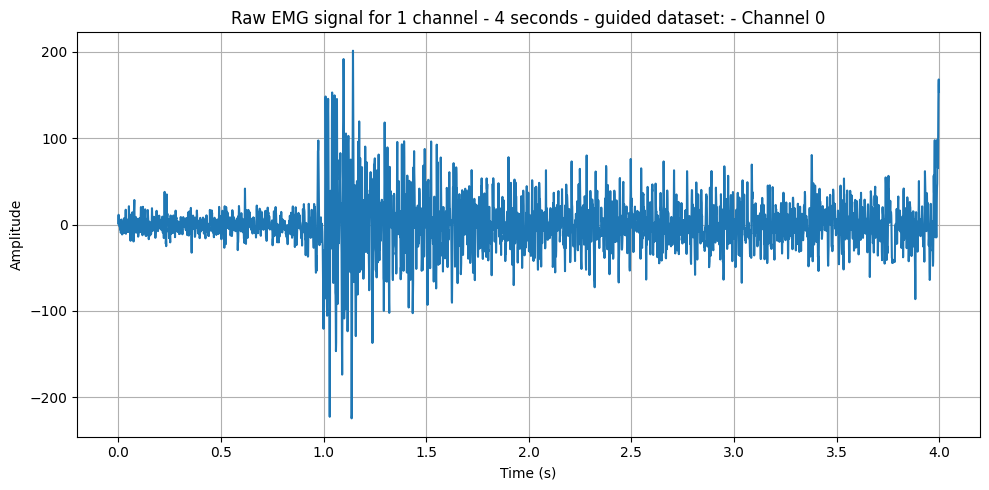

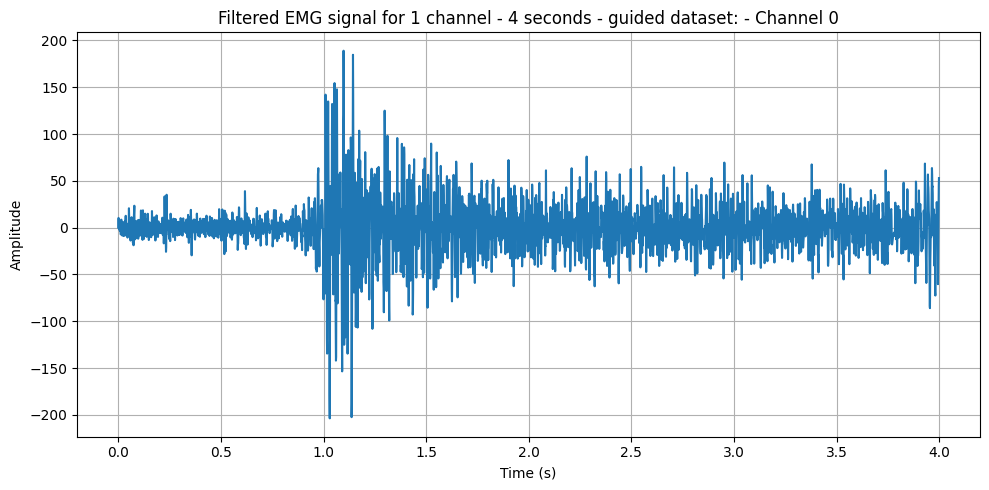

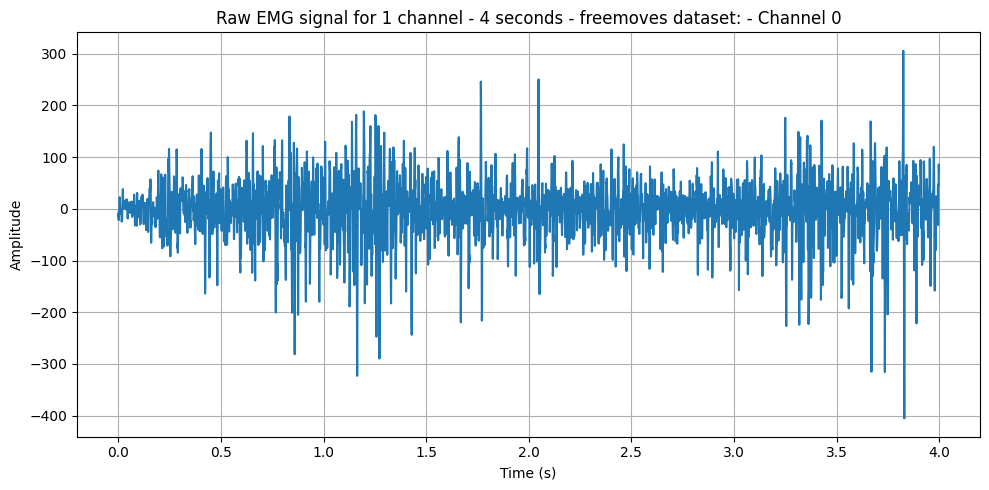

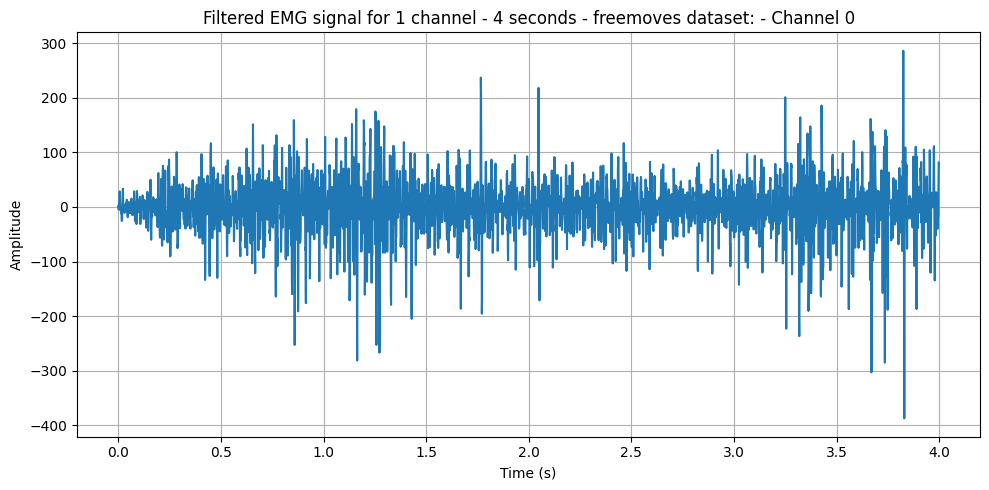

In [ ]:
# Apply filter
X_guided_filter = EmgFilterTransformer().fit_transform(X_guided)
X_freemoves_filter = EmgFilterTransformer().fit_transform(X_freemoves)

# Plots guided
plot_emg_channels(
    X_guided, 
    fs=1024, 
    duration_sec=4,
    title="Raw EMG signal for 1 channel - 4 seconds - guided dataset:", 
    channels_to_plot=[0]
    )
plot_emg_channels(
    X_guided_filter, 
    fs=1024, 
    duration_sec=4,
    title="Filtered EMG signal for 1 channel - 4 seconds - guided dataset:", 
    channels_to_plot=[0]
    )

# Plots freemoves
plot_emg_channels(
    X_freemoves, 
    fs=1024, 
    duration_sec=4,
    title="Raw EMG signal for 1 channel - 4 seconds - freemoves dataset:", 
    channels_to_plot=[0]
    )

plot_emg_channels(
    X_freemoves_filter, 
    fs=1024, 
    duration_sec=4,
    title="Filtered EMG signal for 1 channel - 4 seconds - freemoves dataset:", 
    channels_to_plot=[0]
    )

## (0.5 point) Dataset preparation and augmentation through overlapping windows

You should first segment your sEMG signals into smaller windows of fixed size k = 500. These windows should be created with a chosen degree of overlap, which you can adjust based on the computational and memory resources available to you. Keep in mind that a larger overlap results in a greater number of samples and thus a larger dataset to train your models but to the cost of increasing computational demands.

### Overlapping windows
To prepare our dataset for regression tasks, we segment the continuous surface electromyography (sEMG) signals into smaller overlapping windows of fixed size. This preprocessing step is crucial as it enables the learning models to capture localized temporal patterns in muscle activity and link them to corresponding hand pose estimations.

We chose a **window size `k = 500` samples**, which corresponds to roughly **0.49 seconds** of sEMG data, given the sampling rate of **1024 Hz**. This window size strikes a balance between capturing enough signal dynamics and ensuring real-time usability for prosthesis control.

We implemented a **50% overlap**, meaning each window starts 250 samples after the previous one. This overlap increases the number of training samples without excessively inflating computational costs. Larger overlaps (e.g., 75%) generate even more samples but demand significantly more memory and processing time, which may not scale efficiently depending on available resources.

This approach is implemented using two custom transformer classes:
- `TimeWindowTransformer`: Applies sliding windows to the raw sEMG signals.
- `LabelWindowExtractor`: Aligns the corresponding joint angle labels by sampling at the end of each time window.

This transformation ensures consistent alignment between each input window and its output label, facilitating supervised learning.

In [ ]:
from config.transformers import TimeWindowTransformer, LabelWindowExtractor

# Define parameters
size = 500
step = 250

# Initialize transformers
tw_transformer = TimeWindowTransformer(size=size, step=step)
label_extractor = LabelWindowExtractor(size=size, step=step)

# Apply transformations
X_guided_windows = tw_transformer.transform(X_guided)     # shape: (5, n_windows, 8, 500)
Y_guided_labels = label_extractor.transform(Y_guided)     # shape: (5, n_windows, 51)

X_freemoves_windows = tw_transformer.transform(X_freemoves)     # shape: (5, n_windows, 8, 500)
Y_freemoves_labels = label_extractor.transform(Y_freemoves)     # shape: (5, n_windows, 51)

# Inspect shapes
print("guided:")
print("X_windows shape:", X_guided_windows.shape)
print("Y_labels shape:", Y_guided_labels.shape)
print("freemoves:")
print("X_windows shape:", X_freemoves_windows.shape)
print("Y_labels shape:", Y_freemoves_labels.shape)

X_windows shape: (5, 919, 8, 500)
Y_labels shape: (5, 919, 51)


## (1 point) Cross-validation strategy

Determine and implement an adequate cross-validation strategy to validate your regression models, specifying how you organized your data partitions for training and validation. Provide a detailed justification showing that your validation sets remain completely independent from the training set. Include reasoning or evidence demonstrating explicitly that your chosen partitioning strategy prevents data leakage or bias, ensuring the reliability and generalizability of your model performance estimates.

### Leave-One-Session-Out cross-validation
To rigorously evaluate the performance and generalization capabilities of our regression models, we implemented a **cross-validation strategy** that ensures independence between training and validation data and avoids data leakage.

The available data consists of 5 recording sessions. We use the first **4 sessions** (`X_train_val_folds`, `Y_train_val_folds`) for training and validation, and **reserve the 5th session** (`X_test`, `Y_test`) as a completely unseen test set. This separation allows us to simulate real-world scenarios where the model encounters entirely new data from the same participant.

In [4]:
X_train_val_folds = X_windows[:4]
Y_train_val_folds = Y_labels[:4]
X_test = X_windows[4]
Y_test = Y_labels[4]

Within the five training sessions, we assess the estimator performance by training it on four out of the five sessions of all participants and evaluating it on the “holdout” sessions that the model has never seen. To prevent bias due to potential sessions’ specificities, we use a **Leave-One-Session-Out cross-validation**. The final estimator performance is computed as he root mean squared error (**RMSE**) and normalized mean squared error (**NMSE**) across all five cross validated estimators. This strategy ensures:

- **Complete independence** between training and validation data in each fold
- Robust estimation of the model's performance across different recording sessions
- Reduced risk of overfitting to session-specific artifacts

This strategy provides insights into an estimator’s capacity to generalize to unseen data from new sessions of the same participants. However, it does not provide any information on the estimator’sability to generalize to data from new unseen participants.

> To select the best-performing model configuration, we initially restricted our training data to **only four of the five sessions**. This allowed us to **keep one session completely held out** for **final testing** of generalization on entirely unseen data. Once the optimal model and hyperparameters were selected, we **retrained and validated the model across all five sessions** using the strategy described above. This gave a more complete and reliable estimate of how well the final model generalizes across session variability.

We implemented this strategy creating a 'cross_validate_pipeline' utility function to handle the fold-based evaluation of any sklearn-compatible pipeline:

- Trains on 4 sessions and validates on the 5th (rotating fold)
- Reports both training and validation scores for each fold
- Computes mean performance across all folds for better interpretability

## (3 points) Baseline approach

Create a custom class inheriting from scikit-learn’s `BaseEstimator`
and `TransformerMixin` that implements the extraction of common time-domain features described
in section 3.1. Note that the features described in Section 3.1 represent the minimal required set. We
encourage you to include additional features or preprocessing steps if you would like to further improve your model performances. Select at least two different regression models, compare their cross-validated performance, and evaluate their feature importances. For both models, perform feature selection to determine the optimal subset of features minimizing the Root Mean Squared Error (RMSE).
Clearly document this process in your notebook, discussing the outcomes in detail. Finally, create a
scikit-learn `Pipeline` that integrates your custom feature extraction class, the optimal feature selection step, and the best-performing regression model identified from your cross-validation results.
Using visualizations and tables to illustrate your findings, and employing formulas or pseudo-code
to explain the feature selection procedure, is strongly encouraged. Note that one-third of the score
will depend on the quality and clarity of your documentation.

### Time-domain features
To establish a robust performance benchmark, we designed a baseline approach that uses standard time-domain features extracted from the raw sEMG signal windows. These features have been widely used in EMG-based regression problems due to their low computational cost and effectiveness in capturing muscle activity dynamics.

We created a custom class `TimeDomainTransformer`, inheriting from `BaseEstimator` and `TransformerMixin`, to extract 12 key time-domain features from each EMG channel over a signal window of 500 samples.
These features are computed along the time dimension and include:

- **MAV** – Mean Absolute Value
- **RMS** – Root Mean Square
- **VAR** – Variance
- **STD** – Standard Deviation
- **ZC** – Zero Crossing Count
- **MPR** – Myopulse Percentage Rate (using a tunable threshold `sigma_mpr`)
- **MAA** – Maximum Absolute Amplitude
- **WL** – Waveform Length
- **SSC** – Slope Sign Changes
- **WA** – Wilson Amplitude
- **MFL** – Maximum Fractal Length
- **KRT** – Kurtosis

Each channel of the EMG window (8 in total) produces 12 features, resulting in a final feature vector of size **96** per window.

### Baseline approach
We constructed three baseline pipelines using different regression algorithms to evaluate how well standard time-domain features can predict hand articulation from sEMG signals.

Each pipeline follows the same general structure:

1. **Feature Extraction**  
   Extracts 12 physiological descriptors from each EMG channel using the custom `TimeDomainTransformer`.

2. **Standardization**  
   Normalizes the extracted features using `StandardScaler` to ensure each feature contributes equally to the regression model.

3. **Regression Model**  
   Each pipeline uses a different learning algorithm:
   - **Kernel Ridge Regression** with a Laplacian kernel
   - **K-Nearest Neighbors Regression**
   - **Random Forest Regression**

#### Tuning
To improve the performance of each baseline model, we performed **manual hyperparameter tuning** using an exhaustive grid search strategy. This process is implemented in a dedicated notebook, `tuning_baseline.ipynb`, and applied independently to each pipeline.

For each model, we defined a tailored parameter grid and evaluated all combinations using our cross-validation procedure. The objective is to identify the configuration that minimizes the **validation RMSE**, while also tracking **NMSE** for robustness.

Below is a summary of the parameter grids explored:

- **Time Domain Features + Kernel Ridge**
  - `alpha`: regularization strength
  - `gamma`: kernel coefficient
  - `kernel`: type of kernel (`rbf`, `laplacian`, `poly`)

- **Time Domain Features + KNN**
  - `n_neighbors`: number of nearest neighbors
  - `weights`: uniform or distance-based weighting

- **Time Domain Features + Random Forest**
  - `n_estimators`: number of trees in the forest
  - `max_depth`: depth of each tree
  - `min_samples_split`: minimum samples required to split a node
  - `min_samples_leaf`: minimum samples at a leaf node

Each model is tuned using the following loop:

```python
for model_name, pipeline in models.items():
    print(f"\nTuning Model: {model_name}") 
    results = []

    for params in ParameterGrid(param_grids[model_name]):
        pipeline.set_params(**params)
        scores = cross_validate_pipeline(pipeline, X_train_val_folds, Y_train_val_folds, metric_fns)

        results.append({
            'params': params,
            'mean_train_RMSE': scores['avg_train_RMSE'],
            'mean_val_RMSE': scores['avg_val_RMSE'],
            'mean_train_NMSE': scores['avg_train_NMSE'],
            'mean_val_NMSE': scores['avg_val_NMSE']
        })

    all_results[model_name] = results
```

The results are saved in a seperate json file, allowing us to later analyze the best hyperparameter configuration per model. This tuning step ensures that our baselines are not only functional but also reasonably optimized for performance.

> **DISCLAIMER**

All models and pipelines developed in this project adhere to the following input/output shape requirements to ensure compatibility with the dataset and evaluation routines:

- `model.fit(X, y)`  
  - **Input:**  
    - `X`: NumPy array of shape **(N, 8, 500)** — N windows of raw sEMG signals (8 channels, 500 samples each)  
    - `y`: NumPy array of shape **(N, 51)** — Corresponding joint-angle labels
  - **Note:** This method fits the model in place; the return value is not used.

- `model.predict(X)`  
  - **Input:** `X` of shape **(N, 8, 500)**  
  - **Output:** NumPy array of shape **(N, 51)** — Predicted joint angles

Custom transformers (e.g., for feature extraction) should implement the `fit_transform()` method:
- **Input:** `X` of shape **(N, 8, 500)**
- **Output:** Transformed feature array of shape **(N, ...)**, depending on the specific transformer logic

#### Baseline models - guided

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.kernel_ridge import KernelRidge

from config.transformers import TimeDomainTransformer
from config.validation import RMSE, NMSE, cross_validate_pipeline

In [6]:
baseline_guided_kr = Pipeline(
    [
        ('feature_extraction', TimeDomainTransformer(sigma_mpr=0.3)),
        ('scaler', StandardScaler()),
        ('regressor', KernelRidge(
            alpha = 0.01,
            gamma = 0.01,
            kernel='laplacian'))
    ]
)

baseline_guided_knn = Pipeline(
    [
        ('feature_extraction', TimeDomainTransformer(sigma_mpr=0.3)),
        ('scaler', StandardScaler()),
        ('regressor', KNeighborsRegressor(
            n_neighbors = 5))
    ]
)

baseline_guided_rf = Pipeline(
    [
        ('feature_extraction', TimeDomainTransformer(sigma_mpr=0.3)),
        ('scaler', StandardScaler()),
        ('regressor', RandomForestRegressor(
            n_estimators = 50,
            max_depth = 10))
    ]
)

#### Baseline evaluation

To evaluate these baselines, we applied the **4-fold cross-validation** strategy described previously. For each model, we report both:

- **Root Mean Squared Error (RMSE)**: Measures the average magnitude of prediction errors.
- **Normalized Mean Squared Error (NMSE)**: Indicates performance relative to the variance of the true joint angles.

This setup allows us to compare model performance on a consistent, unbiased basis and analyze the robustness of each approach.

In [7]:
# Evaluation
metric_fns = {'RMSE': RMSE, 'NMSE': NMSE}
models = {
    'Time domain features + Kernel Ridge': baseline_guided_kr,
    'Time domain features + KNN': baseline_guided_knn,
    'Time domain features + Random Forests': baseline_guided_rf
}

for model_name, model in models.items():
    print(f'\nModel: {model_name}')
    result = cross_validate_pipeline(model, X_train_val_folds, Y_train_val_folds, metric_fns, verbose=1)


Model: Time domain features + Kernel Ridge

Average Scores across folds:
RMSE: train=0.1764, val=5.1763
NMSE: train=0.0002, val=0.1354

Model: Time domain features + KNN

Average Scores across folds:
RMSE: train=2.0971, val=4.7569
NMSE: train=0.0219, val=0.1144

Model: Time domain features + Random Forests

Average Scores across folds:
RMSE: train=1.9944, val=5.1086
NMSE: train=0.0198, val=0.1331


#### Features selection
In order to perform feature selection to determine the optimal subset of features minimizing the Root Mean Squared Error (RMSE) we implemeted 2 appraoches: **mRMR (Minimum Redundancy Maximum Relevance)** and **PCA**

##### mRMR
This section explains how features are ranked and selected using the **Minimum Redundancy Maximum Relevance (mRMR)** strategy, based on a correlation-based approximation of mutual information.
To estimate the relevance of each feature to the outputs (joint angles), we approximate **Mutual Information (MI)** using the correlation coefficient:

$$
\text{MI}(x, y) \approx -\frac{1}{2} \log(1 - \rho^2)
$$

Where:
- $\rho$ is the **Pearson correlation coefficient**
- This approximation assumes **joint Gaussianity**

```python
def mutual_info_corr(x, y):
    """
    Approximates mutual information between x and y via Pearson correlation.
    """
    c = np.corrcoef(x, y)[0, 1]
    if abs(c) == 1:
        c = 0.999999  # avoid division by zero
    return -0.5 * np.log(1 - c**2)
```

The algorithm iteratively selects the next feature that maximizes:
\[
\text{mRMR}_j = \text{Relevance}_j - \text{Redundancy}_j
\]

Where:
- **Relevance**: average MI between the candidate feature and all outputs
- **Redundancy**: average MI between the candidate and all already-selected features

```python
def greedy_mrmr_selection(X_df, mi_scores):
    selected = []
    candidates = list(range(X_df.shape[1]))

    for _ in range(len(candidates)):
        redundancy = ...
        mrmr_score = mi_scores[candidates] - redundancy
        best = candidates[np.argmax(mrmr_score)]
        selected.append(best)
        candidates.remove(best)
    return selected
```

For each subset of selected features from size 1 to N:
- Build a scikit-learn pipeline with the regressor
- Use cross_validate_pipeline() to compute the average RMSE across folds
- Evaluate mean Validation RMSE per fold

After evaluating all subsets, a plot is created showing RMSE (with error bars) as features are added together with dot colors indicating the type of time-domain feature (e.g., MAV, RMS, etc.)

In [ ]:
from config.validation import mutual_info_corr, compute_mi_vector, greedy_mrmr_selection
from config.transformers import FeatureSelector

# Compute Mutual Info (includes feature extraction)
X_df, Y_all, mi_scores, X_sessions = compute_mi_vector(X_train_val_folds, Y_train_val_folds, TimeDomainTransformer(sigma_mpr=0.3))

# Perform mRMR
selected = greedy_mrmr_selection(X_df, mi_scores)

# Evaluation
n_features = len(selected)
n_sessions = X_sessions.shape[0]
CV_err_mrmr = np.zeros((n_features, n_sessions))

for nb_features in range(1, n_features + 1):
    selected_indices = selected[:nb_features]
    pipeline = Pipeline([
        ('select', FeatureSelector(selected_indices)),
        ('scale', StandardScaler()),
        ('reg', KernelRidge(
            alpha=0.01, 
            gamma=0.01, 
            kernel='laplacian'))
    ])
    cv_results = cross_validate_pipeline(
        pipeline, 
        X_sessions, 
        Y_train_val_folds,
        metric_fns={'RMSE': RMSE}, 
        n_folds=n_sessions, 
        verbose=0
    )
    for fold_id in range(n_sessions):
        CV_err_mrmr[nb_features - 1, fold_id] = cv_results[fold_id]['val_RMSE']

# Report results
print("\nmRMR Feature Selection with Kernel Ridge")
for i in range(n_features):
    print(f"#Features: {i+1}; CV error = {CV_err_mrmr[i,:].mean():.4f}; std dev = {CV_err_mrmr[i,:].std():.4f}")

print("\nSelected feature ranking (by column index):")
print(selected)



mRMR Feature Selection with Multi-Output Regression
#Features: 1; CV error = 12.1624; std dev = 0.1727
#Features: 2; CV error = 10.3837; std dev = 0.5100
#Features: 3; CV error = 9.9987; std dev = 0.6440
#Features: 4; CV error = 9.7973; std dev = 0.7752
#Features: 5; CV error = 9.6121; std dev = 0.7060
#Features: 6; CV error = 9.5482; std dev = 0.8101
#Features: 7; CV error = 9.5838; std dev = 0.8135
#Features: 8; CV error = 9.1600; std dev = 0.6959
#Features: 9; CV error = 9.1415; std dev = 0.6667
#Features: 10; CV error = 7.2972; std dev = 0.8519
#Features: 11; CV error = 7.3302; std dev = 0.8226
#Features: 12; CV error = 7.3476; std dev = 0.8073
#Features: 13; CV error = 7.0713; std dev = 0.6807
#Features: 14; CV error = 7.0493; std dev = 0.6829
#Features: 15; CV error = 7.0057; std dev = 0.6790
#Features: 16; CV error = 7.0285; std dev = 0.6924
#Features: 17; CV error = 6.3715; std dev = 0.6095
#Features: 18; CV error = 6.3611; std dev = 0.6115
#Features: 19; CV error = 6.3987; st

C:\Users\gianm\AppData\Local\Temp\ipykernel_50676\2031987167.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', len(unique_types))


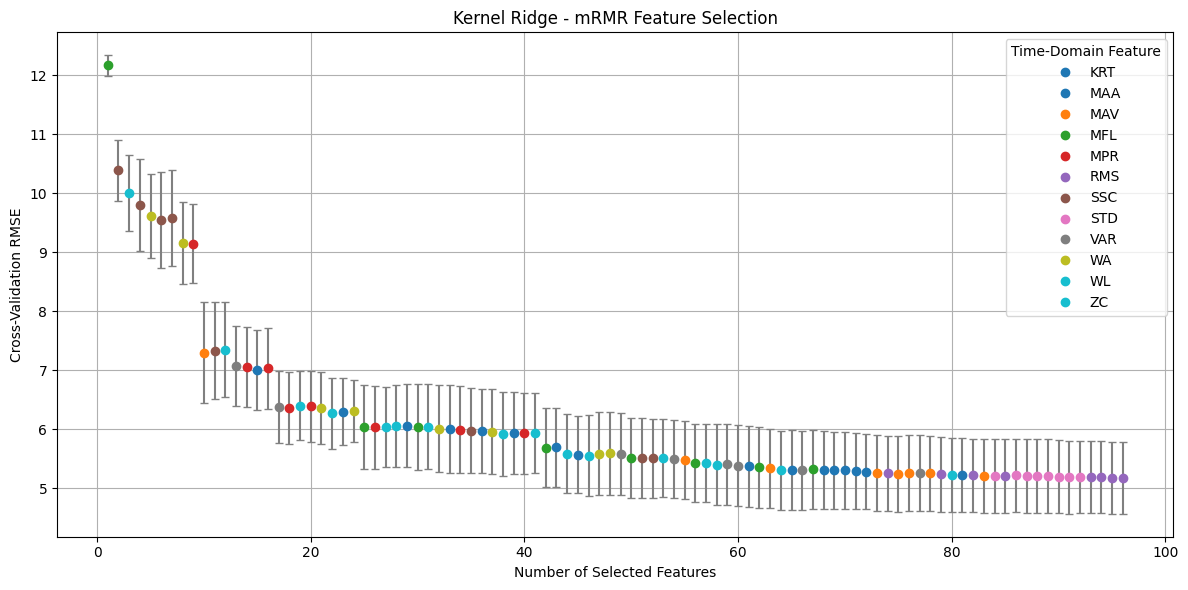

In [ ]:
from config.utils import plot_mrmr_results

# Plot mRMR Feature Selection
plot_mrmr_results(
    selected,
    CV_err_mrmr,
    td_feature_names=['MAV', 'RMS', 'VAR', 'STD', 'ZC', 'MPR',
                      'MAA', 'WL', 'SSC', 'WA', 'MFL', 'KRT'],
    model_name='Kernel Ridge'
)

In [9]:
from config.validation import mutual_info_corr, compute_mi_vector, greedy_mrmr_selection
from config.transformers import FeatureSelector

# Compute Mutual Info (includes feature extraction)
X_df, Y_all, mi_scores, X_sessions = compute_mi_vector(X_train_val_folds, Y_train_val_folds, TimeDomainTransformer(sigma_mpr=0.3))

# Perform mRMR
selected = greedy_mrmr_selection(X_df, mi_scores)

# Evaluation
n_features = len(selected)
n_sessions = X_sessions.shape[0]
CV_err_mrmr = np.zeros((n_features, n_sessions))

for nb_features in range(1, n_features + 1):
    selected_indices = selected[:nb_features]
    pipeline = Pipeline([
        ('select', FeatureSelector(selected_indices)),
        ('scale', StandardScaler()),
        ('reg', KNeighborsRegressor(
            n_neighbors = 5))
    ])
    cv_results = cross_validate_pipeline(
        pipeline, 
        X_sessions, 
        Y_train_val_folds,
        metric_fns={'RMSE': RMSE}, 
        n_folds=n_sessions, 
        verbose=0
    )
    for fold_id in range(n_sessions):
        CV_err_mrmr[nb_features - 1, fold_id] = cv_results[fold_id]['val_RMSE']

# Report results
print("\nmRMR Feature Selection with KNN")
for i in range(n_features):
    print(f"#Features: {i+1}; CV error = {CV_err_mrmr[i,:].mean():.4f}; std dev = {CV_err_mrmr[i,:].std():.4f}")

print("\nSelected feature ranking (by column index):")
print(selected)


mRMR Feature Selection with KNN
#Features: 1; CV error = 13.2282; std dev = 0.1855
#Features: 2; CV error = 11.1306; std dev = 0.5925
#Features: 3; CV error = 10.5179; std dev = 0.8145
#Features: 4; CV error = 10.1012; std dev = 1.1634
#Features: 5; CV error = 9.7119; std dev = 0.9338
#Features: 6; CV error = 9.5014; std dev = 0.9583
#Features: 7; CV error = 9.5535; std dev = 1.1317
#Features: 8; CV error = 9.1052; std dev = 0.9159
#Features: 9; CV error = 8.9546; std dev = 0.9007
#Features: 10; CV error = 7.0679; std dev = 0.8932
#Features: 11; CV error = 7.0507; std dev = 0.8194
#Features: 12; CV error = 7.2098; std dev = 0.7892
#Features: 13; CV error = 7.1682; std dev = 0.7574
#Features: 14; CV error = 6.9093; std dev = 0.8953
#Features: 15; CV error = 6.7399; std dev = 0.9708
#Features: 16; CV error = 6.8071; std dev = 0.9136
#Features: 17; CV error = 6.4845; std dev = 0.9391
#Features: 18; CV error = 6.5491; std dev = 0.9249
#Features: 19; CV error = 6.6354; std dev = 0.8044
#Fe

C:\Users\gianm\AppData\Local\Temp\ipykernel_50676\2031987167.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', len(unique_types))


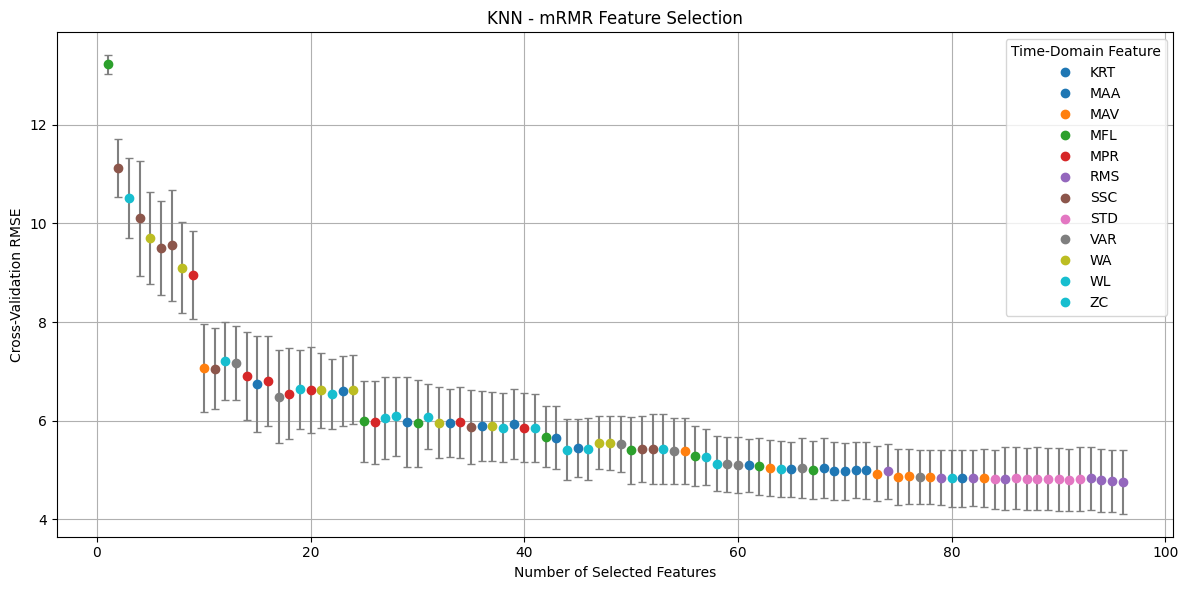

In [ ]:
# Plot mRMR Feature Selection
plot_mrmr_results(
    selected,
    CV_err_mrmr,
    td_feature_names=['MAV', 'RMS', 'VAR', 'STD', 'ZC', 'MPR',
                      'MAA', 'WL', 'SSC', 'WA', 'MFL', 'KRT'],
    model_name='KNN'
)

We evaluated RMSE across varying numbers of selected features using leave-one-session-out cross-validation. Here are the results near the optimal region (number reported for Kernel Ridge):
```text
#Features: 80; CV error = 5.2161; std dev = 0.6287  
#Features: 81; CV error = 5.2204; std dev = 0.6276  
#Features: 82; CV error = 5.2140; std dev = 0.6210  
#Features: 85; CV error = 5.2095; std dev = 0.6255  
#Features: 90; CV error = 5.1963; std dev = 0.6175  
#Features: 95; CV error = 5.1783; std dev = 0.6114  
#Features: 96; CV error = 5.1763; std dev = 0.6115  
```
The results show that after 80 features, additional features provide very marginal improvements in RMSE. This is visually confirmed in the plots "Regressor – mRMR Feature Selection".

To integrate feature selection directly into the learning pipeline, we implemented the TopKMRMRSelector class as a custom scikit-learn transformer. This enables end-to-end model training and evaluation without requiring separate preprocessing steps.
By setting k=80, we include only the most relevant features identified by mRMR, improving interpretability and reducing the dimensionality of 16 dimensions.

In [8]:
from config.transformers import TopKMRMRSelector

baseline_guided_kr = Pipeline(
    [
        ('feature_extraction', TimeDomainTransformer(sigma_mpr=0.3)),
        ('scaler', StandardScaler()),
        ('feature_select', TopKMRMRSelector(k=80)),
        ('regressor', KernelRidge(
            alpha = 0.01,
            gamma = 0.01,
            kernel='laplacian'))
    ]
)

baseline_guided_knn = Pipeline(
    [
        ('feature_extraction', TimeDomainTransformer(sigma_mpr=0.3)),
        ('scaler', StandardScaler()),
        ('feature_select', TopKMRMRSelector(k=80)),
        ('regressor', KNeighborsRegressor(
            n_neighbors = 5))
    ]
)

# Evaluation
metric_fns = {'RMSE': RMSE, 'NMSE': NMSE}
models = {
    'Time domain features + Kernel Ridge': baseline_guided_kr,
    'Time domain features + KNN': baseline_guided_knn,
}

for model_name, model in models.items():
    print(f'\nModel: {model_name}')
    result = cross_validate_pipeline(model, X_train_val_folds, Y_train_val_folds, metric_fns, verbose=1)


Model: Time domain features + Kernel Ridge

Average Scores across folds:
RMSE: train=0.2133, val=5.2239
NMSE: train=0.0002, val=0.1380

Model: Time domain features + KNN

Average Scores across folds:
RMSE: train=2.1727, val=4.8403
NMSE: train=0.0235, val=0.1182


##### PCA
This section explains how **Principal Component Analysis (PCA)** is used as a feature selection and dimensionality reduction technique to improve regression performance from EMG time-domain features.

We evaluate PCA-based dimensionality reduction by retaining different levels of explained variance:

```python
variance_thresholds = np.arange(0.85, 0.991, 0.01)
```

For each subset of selected features from size 1 to N:
- Build a scikit-learn pipeline with the regressor
- Use cross_validate_pipeline() to compute the average RMSE across folds
- Evaluate mean Validation RMSE per fold
- Fit PCA separately to compute the actual number of components retained at that threshold

We generate two plots (as subplots in one figure):

- **RMSE vs. Variance Retained**: Shows how performance changes as we retain more principal components
- **Components vs. Variance Retained**: Visualizes the dimensionality reduction effect of PCA


Model Kernel Ridge
Variance: 0.85, RMSE: 5.3779, Components: 13
Variance: 0.86, RMSE: 5.3686, Components: 14
Variance: 0.87, RMSE: 5.3243, Components: 15
Variance: 0.88, RMSE: 5.3127, Components: 16
Variance: 0.89, RMSE: 5.2986, Components: 18
Variance: 0.90, RMSE: 5.3138, Components: 19
Variance: 0.91, RMSE: 5.2954, Components: 21
Variance: 0.92, RMSE: 5.2992, Components: 23
Variance: 0.93, RMSE: 5.3092, Components: 25
Variance: 0.94, RMSE: 5.3576, Components: 27
Variance: 0.95, RMSE: 5.3544, Components: 29
Variance: 0.96, RMSE: 5.3499, Components: 32
Variance: 0.97, RMSE: 5.3893, Components: 36
Variance: 0.98, RMSE: 5.3679, Components: 41
Variance: 0.99, RMSE: 5.3560, Components: 48


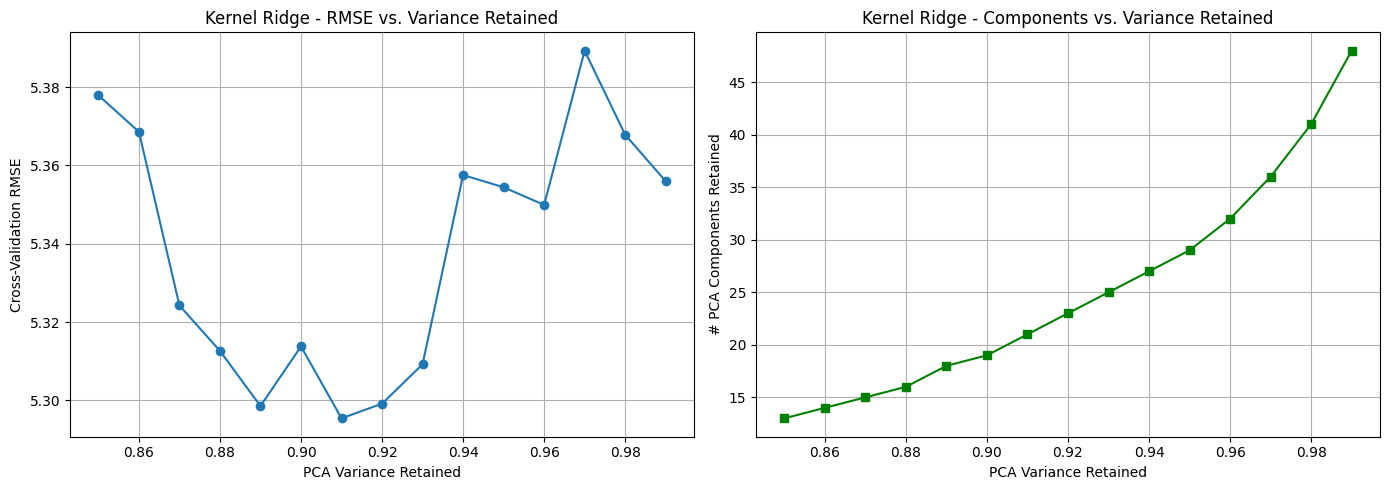

In [40]:
# Prepare inputs
from sklearn.decomposition import PCA

n_sessions, n_windows, n_channels, window_size = X_train_val_folds.shape

# Sweep PCA variance thresholds
variance_thresholds = np.arange(0.85, 0.991, 0.01)
nmse_scores = []
n_components_used = []

print("\nModel Kernel Ridge")
for var in variance_thresholds:
    pipeline = Pipeline([
        ('td_feat', TimeDomainTransformer()),
        ('scale', StandardScaler()),
        ('pca', PCA(n_components=float(var), random_state=42)),
        ('reg', KernelRidge(
            alpha = 0.01,
            gamma = 0.01,
            kernel='laplacian'))
    ])

    metric_fns = {'RMSE': RMSE}
    results = cross_validate_pipeline(
        pipeline,
        X_train_val_folds,
        Y_train_val_folds,
        metric_fns=metric_fns,
        verbose=0
    )

    # Fit once to extract # of components
    pipeline.fit(X_train_val_folds.reshape(-1, n_channels, window_size), Y_train_val_folds.reshape(-1, 51))
    n_comp = pipeline.named_steps['pca'].n_components_

    nmse_scores.append(results['avg_val_RMSE'])
    n_components_used.append(n_comp)

    print(f"Variance: {var:.2f}, RMSE: {results['avg_val_RMSE']:.4f}, Components: {n_comp}")

# Plots
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: RMSE vs Variance Retained
axs[0].plot(variance_thresholds, nmse_scores, marker='o')
axs[0].set_xlabel("PCA Variance Retained")
axs[0].set_ylabel("Cross-Validation RMSE")
axs[0].set_title("Kernel Ridge - RMSE vs. Variance Retained")
axs[0].grid(True)

# Plot 2: #Components vs Variance Retained
axs[1].plot(variance_thresholds, n_components_used, marker='s', color='green')
axs[1].set_xlabel("PCA Variance Retained")
axs[1].set_ylabel("# PCA Components Retained")
axs[1].set_title("Kernel Ridge - Components vs. Variance Retained")
axs[1].grid(True)

plt.tight_layout()
plt.show()


Model KNN
Variance: 0.85, RMSE: 4.6828, Components: 13
Variance: 0.86, RMSE: 4.7069, Components: 14
Variance: 0.87, RMSE: 4.6806, Components: 15
Variance: 0.88, RMSE: 4.7006, Components: 16
Variance: 0.89, RMSE: 4.7275, Components: 18
Variance: 0.90, RMSE: 4.7079, Components: 19
Variance: 0.91, RMSE: 4.6922, Components: 21
Variance: 0.92, RMSE: 4.6976, Components: 23
Variance: 0.93, RMSE: 4.6790, Components: 25
Variance: 0.94, RMSE: 4.6994, Components: 27
Variance: 0.95, RMSE: 4.7007, Components: 29
Variance: 0.96, RMSE: 4.7096, Components: 32
Variance: 0.97, RMSE: 4.7091, Components: 36
Variance: 0.98, RMSE: 4.7052, Components: 41
Variance: 0.99, RMSE: 4.6980, Components: 48


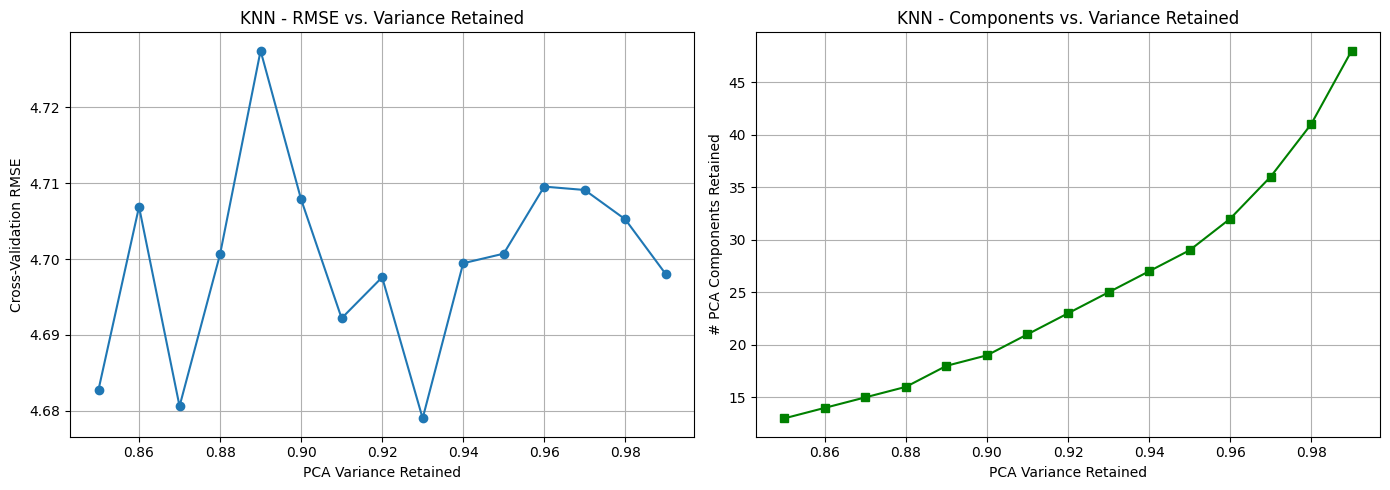

In [41]:
# Sweep PCA variance thresholds
variance_thresholds = np.arange(0.85, 0.991, 0.01)
nmse_scores = []
n_components_used = []

print("\nModel KNN")
for var in variance_thresholds:
    pipeline = Pipeline([
        ('td_feat', TimeDomainTransformer()),
        ('scale', StandardScaler()),
        ('pca', PCA(n_components=float(var), random_state=42)),
        ('reg', KNeighborsRegressor(
            n_neighbors = 5))
    ])

    metric_fns = {'RMSE': RMSE}
    results = cross_validate_pipeline(
        pipeline,
        X_train_val_folds,
        Y_train_val_folds,
        metric_fns=metric_fns,
        verbose=0
    )

    # Fit once to extract # of components
    pipeline.fit(X_train_val_folds.reshape(-1, n_channels, window_size), Y_train_val_folds.reshape(-1, 51))
    n_comp = pipeline.named_steps['pca'].n_components_

    nmse_scores.append(results['avg_val_RMSE'])
    n_components_used.append(n_comp)

    print(f"Variance: {var:.2f}, RMSE: {results['avg_val_RMSE']:.4f}, Components: {n_comp}")

# Plots
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: RMSE vs Variance Retained
axs[0].plot(variance_thresholds, nmse_scores, marker='o')
axs[0].set_xlabel("PCA Variance Retained")
axs[0].set_ylabel("Cross-Validation RMSE")
axs[0].set_title("KNN - RMSE vs. Variance Retained")
axs[0].grid(True)

# Plot 2: #Components vs Variance Retained
axs[1].plot(variance_thresholds, n_components_used, marker='s', color='green')
axs[1].set_xlabel("PCA Variance Retained")
axs[1].set_ylabel("# PCA Components Retained")
axs[1].set_title("KNN - Components vs. Variance Retained")
axs[1].grid(True)

plt.tight_layout()
plt.show()

TO-DO: Explain which threshold we pick for PCA and why

## (2 points) More sophisticated approach
Implement a regression model based on either the covariance matrices (3.2) pipeline described above or a neural network approach using the PyTorch library. Optionally, you can implement both approaches. Assess its cross-validated performance with respect to the baseline approach and discuss the results. The use of figures, formulas, tables and pseudo-code to describe this approach is again strongly encouraged. Note that one-third of the score will depend on the quality and clarity of your documentation.

### Riemannian Geometry-Based Pipelines 
These pipelines use the geometry of covariance matrices to extract robust features from multichannel EMG signals. Leveraging **Riemannian geometry**, this method is well-suited for structured signals like EEG or EMG.

Common Pipeline structure:

1. **Covariance Estimation**  
   `pyriemann.estimation.Covariances()`  
   - Computes the covariance matrix from EMG channels per time window.

2. **Tangent Space Projection**  
   `pyriemann.tangentspace.TangentSpace(metric='riemann', tsupdate=True)`  
   - Projects the SPD matrices onto the tangent space at the Riemannian mean.
   - `tsupdate=True` allows updating the tangent space mean at transform time.

3. **Feature Scaling**  
   `StandardScaler()`  
   - Standard normalization to mean 0 and unit variance.

4. **Regression Model**  
   - Varies across pipelines below.

As regression model we used:
- Kernel Ridge
- KNN
- Random Forest

E.g.: Kernel Ridge Regression
```python
riem1 = Pipeline([
    ('feature_extraction', Covariances()),
    ('transformation', TangentSpace(metric='riemann', tsupdate=True)),
    ('scaler', StandardScaler()),
    ('regressor', KernelRidge(
            alpha=0.01, 
            gamma=0.01, 
            kernel='laplacian'))
])

In [8]:
import pyriemann
import pyriemann.regression
from sklearn.multioutput import MultiOutputRegressor

In [9]:
# Riemannian geometry of covariance matrices
riem1 = Pipeline(
    [
        ('feature_extraction', pyriemann.estimation.Covariances()),
        ('transformation', pyriemann.tangentspace.TangentSpace(
            metric = 'riemann',
            tsupdate = True)),
        ('scaler', StandardScaler()),
        ('regressor', KernelRidge(
            alpha = 0.01,
            gamma = 0.01,
            kernel='laplacian'))
    ]
)

riem2 = Pipeline(
    [
        ('feature_extraction', pyriemann.estimation.Covariances()),
        ('transformation', pyriemann.tangentspace.TangentSpace(
            metric = 'riemann',
            tsupdate = True)),
        ('scaler', StandardScaler()),
        ('regressor', KNeighborsRegressor(
            n_neighbors = 5))
    ]
)

riem3 = Pipeline(
    [
        ('feature_extraction', pyriemann.estimation.Covariances()),
        ('transformation', pyriemann.tangentspace.TangentSpace(
            metric = 'riemann',
            tsupdate = True)),
        ('scaler', StandardScaler()),
        ('regressor', RandomForestRegressor(
            n_estimators = 50,
            max_depth = 10))
    ]
)

In [10]:
# Evaluation
metric_fns = {'RMSE': RMSE, 'NMSE': NMSE}
models = {
    'Riemann + Kernel Ridge': riem1,
    'Riemann + KNN': riem2,
    'Riemann + Random Forest': riem3
}

for model_name, model in models.items():
    print(f'\nModel: {model_name}')
    result = cross_validate_pipeline(model, X_train_val_folds, Y_train_val_folds, metric_fns, verbose=1)


Model: Riemann + Kernel Ridge

Average Scores across folds:
RMSE: train=0.5305, val=5.5466
NMSE: train=0.0014, val=0.1548

Model: Riemann + KNN

Average Scores across folds:
RMSE: train=3.2994, val=5.8645
NMSE: train=0.0543, val=0.1764

Model: Riemann + Random Forest

Average Scores across folds:
RMSE: train=2.1553, val=4.8815
NMSE: train=0.0232, val=0.1216


## (3 points) Ensemble
Design and implement two ensembling strategies that combine the predictions of all individual regression models you implemented, each independently trained on distinct feature representations of the EMG signals. The two required ensembling approaches are the following:
- Compute the average of the predicted values
- Use a meta-learner strategy (often referred to as stacking), in which a separate model—trained on the outputs of the base learners—generates the ensemble prediction
For each ensemble strategy, compare and document the ensemble’s regression performance against each of its constituent base models using consistent regression metrics. Additionally, for the metalearner strategy, determine and discuss the relative contribution of each base model to the final ensemble prediction. Discuss how the bias-variance tradeoff relates to the observed (or expected) evolution of performance.

### Ensemble regressors
TO-DO: add descripton

In [11]:
from config.regressors import VotingRegressor, StackingRegressor

In [12]:
voting_estimator = VotingRegressor(
    estimators = [
        baseline_guided_kr,
        baseline_guided_knn,
        baseline_guided_rf,
        riem1,
        riem2,
        riem3
    ]
)

result = cross_validate_pipeline(voting_estimator, X_train_val_folds, Y_train_val_folds, metric_fns, verbose=2)


Fold 1
RMSE: train=1.3993, val=3.6947
NMSE: train=0.0097, val=0.0704

Fold 2
RMSE: train=1.3329, val=4.6125
NMSE: train=0.0088, val=0.1081

Fold 3
RMSE: train=1.3666, val=5.4712
NMSE: train=0.0095, val=0.1406

Fold 4
RMSE: train=1.3593, val=3.7139
NMSE: train=0.0091, val=0.0699

Average Scores across folds:
RMSE: train=1.3645, val=4.3731
NMSE: train=0.0093, val=0.0973


In [14]:
stacking_estimator = StackingRegressor(
    estimators = [
        baseline_guided_kr,
        baseline_guided_knn,
        baseline_guided_rf,
        riem1,
        riem2,
        riem3
    ],
    end_estimator = RandomForestRegressor(
        n_estimators = 50,
        max_depth = 10)
)

result = cross_validate_pipeline(stacking_estimator, X_train_val_folds, Y_train_val_folds, metric_fns, verbose=2)


Fold 1
RMSE: train=0.6950, val=4.5792
NMSE: train=0.0024, val=0.1082

Fold 2
RMSE: train=0.6892, val=4.7098
NMSE: train=0.0024, val=0.1127

Fold 3
RMSE: train=0.6675, val=5.0928
NMSE: train=0.0023, val=0.1218

Fold 4
RMSE: train=0.6587, val=3.9426
NMSE: train=0.0021, val=0.0788

Average Scores across folds:
RMSE: train=0.6776, val=4.5811
NMSE: train=0.0023, val=0.1054


### Estimator validation

### Visualizing predictions to unseen data

In [ ]:
X_train_val_flat = X_train_val_folds.reshape(-1, *X_train_val_folds.shape[2:])
Y_train_val_flat = Y_train_val_folds.reshape(-1, *Y_train_val_folds.shape[2:])

model = ensemble_estimator

model.fit(X_train_val_flat, Y_train_val_flat)
Y_train_pred = model.predict(X_train_val_flat)
Y_test_pred = model.predict(X_test)

print(f"train RMSE:\t{RMSE(Y_train_pred, Y_train_val_flat):.4f}\ttrain NMSE:\t{NMSE(Y_train_pred, Y_train_val_flat):.4f}")
print(f"test RMSE:\t{RMSE(Y_test_pred, Y_test):.4f}\ttest NMSE:\t{NMSE(Y_test_pred, Y_test):.4f}")

In [ ]:
from config.utils import scatter_3d_points

bone = 6
Y_true_bone = Y_test[:,3*bone:3*(bone+1)]
Y_pred_bone = Y_test_pred[:,3*bone:3*(bone+1)]

print(f'RMSE for bone {bone}:', RMSE(Y_pred_bone, Y_true_bone))
print(f'NMSE for bone {bone}:', NMSE(Y_pred_bone, Y_true_bone))

ax = scatter_3d_points(Y_true_bone, color = 'b')
scatter_3d_points(Y_pred_bone, color = 'r', ax = ax)
# ax.set_xlim3d(-50, 50)
# ax.set_ylim3d(-50, 50)
# ax.set_zlim3d(-50, 50)
plt.show()